LIEW WEI BRIAN (A0239041M)

# Task 1: AWS S3 Data Storage

## Screenshot 1: AWS S3 bucket with sales_data_sample.csv uploaded:



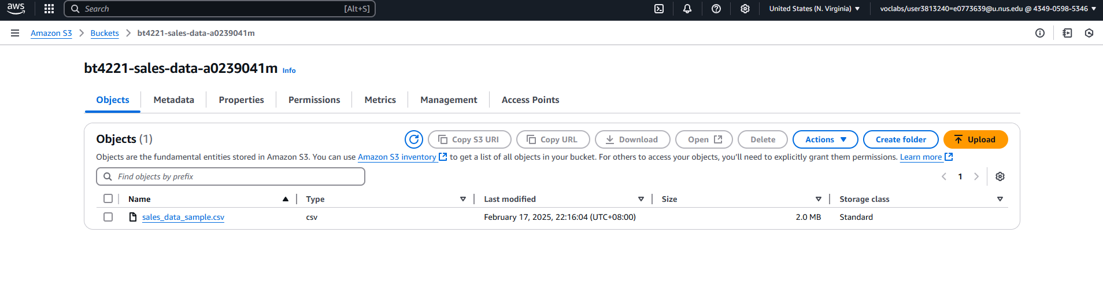

##Short explanation (150-200 words) on automation strategy:

This process can be automated using AWS Glue Workflow, which automatically triggers (scheduled/on-demand) the following 2 ETL jobs in seqeuence:

1. AWS Glue ETL Job 1 - S3 Bucket Creation Job (Python Shell Script)
- Python Shell Script in AWS Glue checks whether S3 bucket (bt4221-sales-data-{your_studentID}) exists. If the bucket does not exist, the job automatically creates it. A retry limit of such as 5 can be set to ensure that any failures such as AWS API failures are handled.

2. AWS Glue ETL Job 2 - Sales Data Upload Job (Python Shell Script)
- After successful run of ETL Job 1 and creation of S3 Bucket (bt4221-sales-data-{your_studentID}), the second AWS Glue ETL job uploads the sales data CSV (sales_data_sample.csv) to the newly created S3 bucket.
This job is also configured with a maximum retry limit of 5 for reliability.





# Task 2: AWS Glue ETL


## Screenshot 1: AWS Glue Crawler and Data Catalog table:

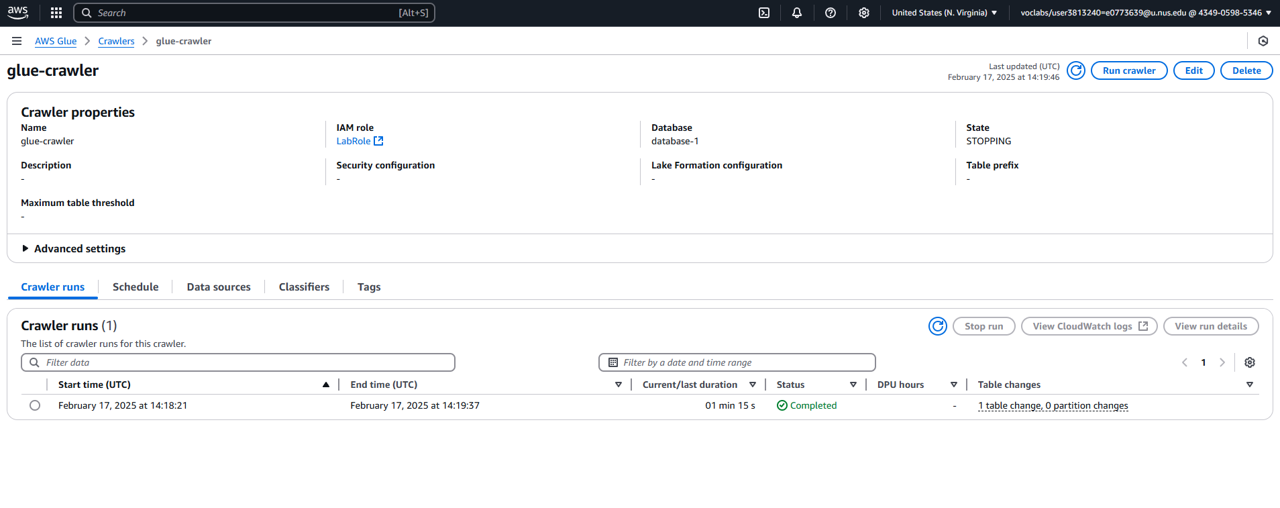

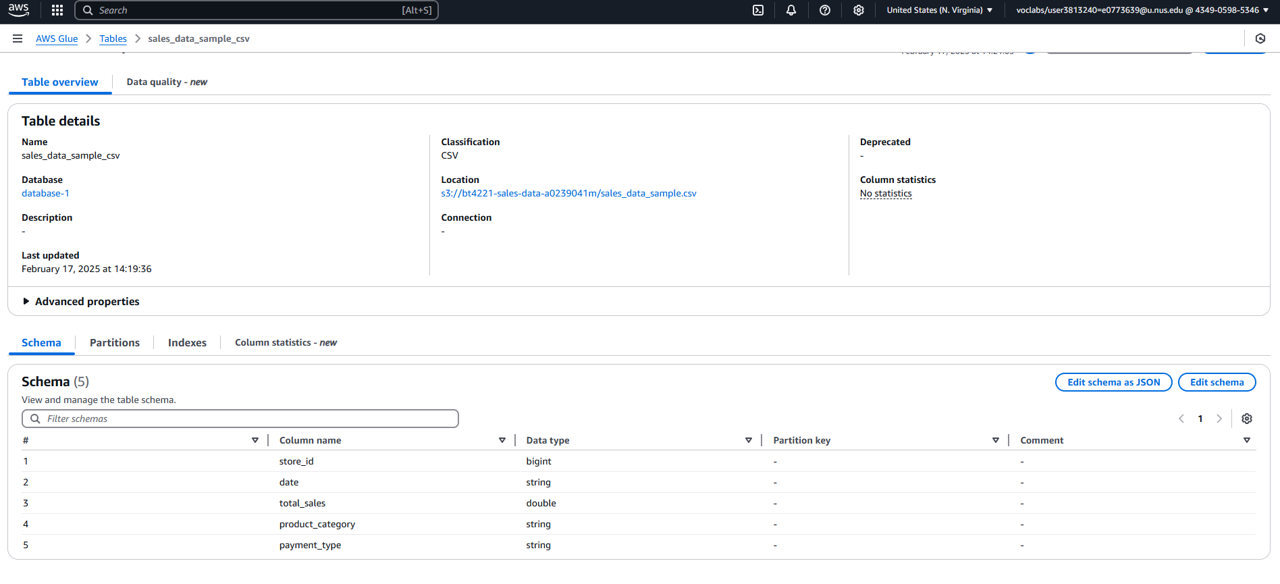

##Short description (150-200 words) of the cleaning steps applied:

The AWS Glue ETL job processes raw sales data from S3 bucket bt4221-sales-data-a0239041m, cleans it, and saves the transformed dataset to S3 bucket bt4221-cleaned-sales-data-a0239041m.


1. Input Data Source (S3 Bucket) - "bt4221-sales-data-a0239041m"
2. Remove Duplicates
- Remove Duplicates using Match Entire Row - use all fields to compare between rows, and only remove rows that match in all of them

3. Using SQL Query to Drop Null Fields
- Remove missing/null values for Total_Sales column & Product_Category column <br>
- SELECT * <br> FROM myDataSource <br> WHERE total_sales IS NOT NULL <br> AND TRIM(total_sales) != '' AND product_category IS NOT NULL AND TRIM(product_category) != '';

4. Use SQL Query to Standardise casing for Payment_Type column
- Converts all values to lowercase then capitalizes the first letter of each word. This removes inconsistencies in Payment_Type values, such as "CASH" | "Cash" | "cash", which will be converted to "Cash". <br>
- SELECT Store_ID, Date, Total_Sales, Product_Category, INITCAP(LOWER(payment_type)) AS Payment_Type <br> FROM myDataSource;

5. Change Data Types
- Store_Id to integer
- Date to date
- Total_Sales to decimal
- Product_Category to string
- Payment Type to string

6. Output to new S3 Bucket - "bt4221-cleaned-sales-data-a0239041m"
- Create a Glue Data Catalog table for the data

## Screenshot 2: AWS Glue ETL job configuration and execution results:

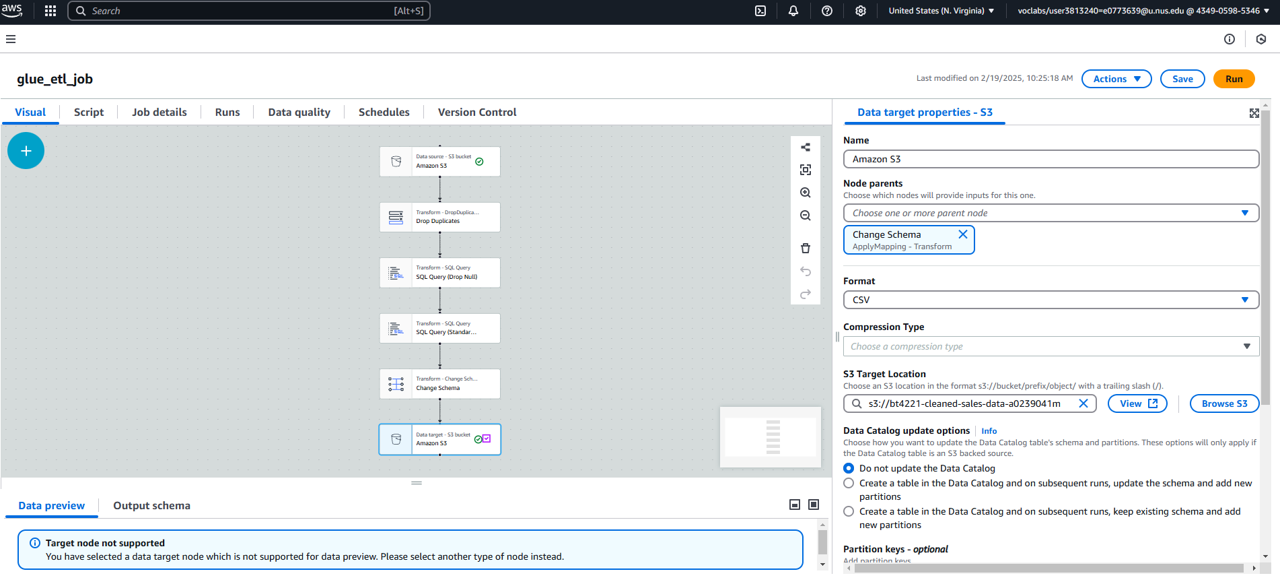

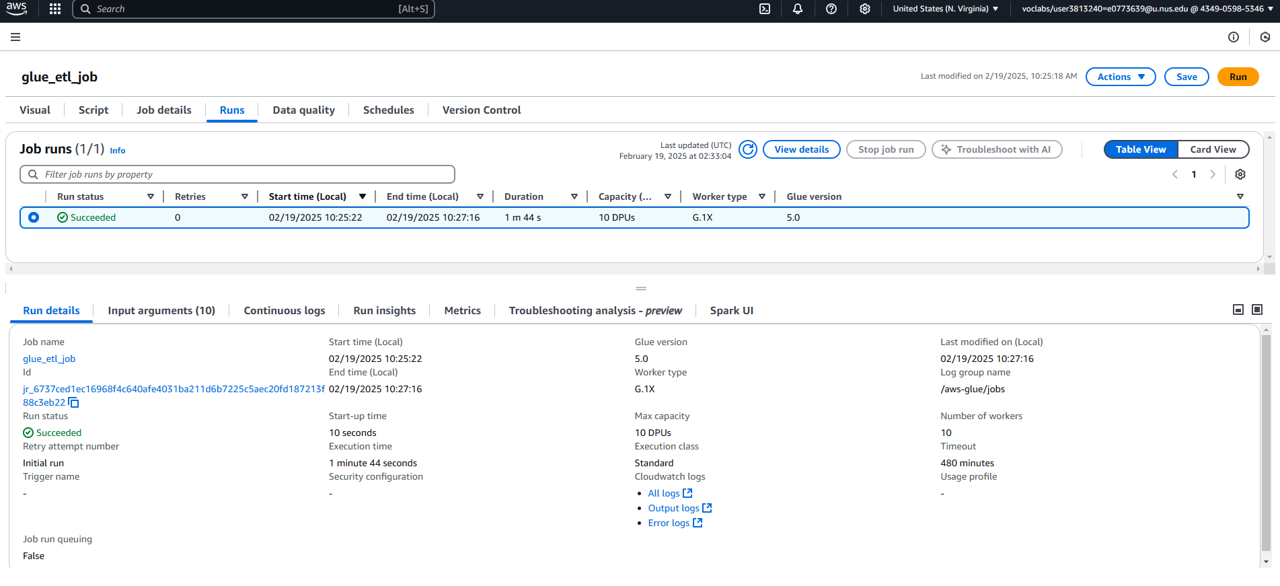

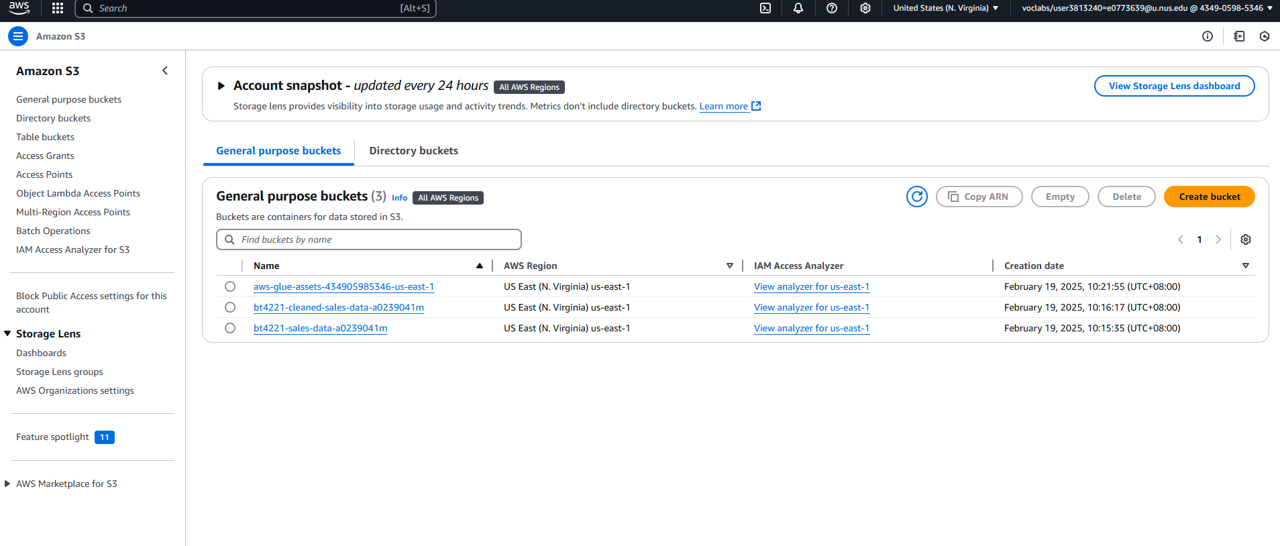

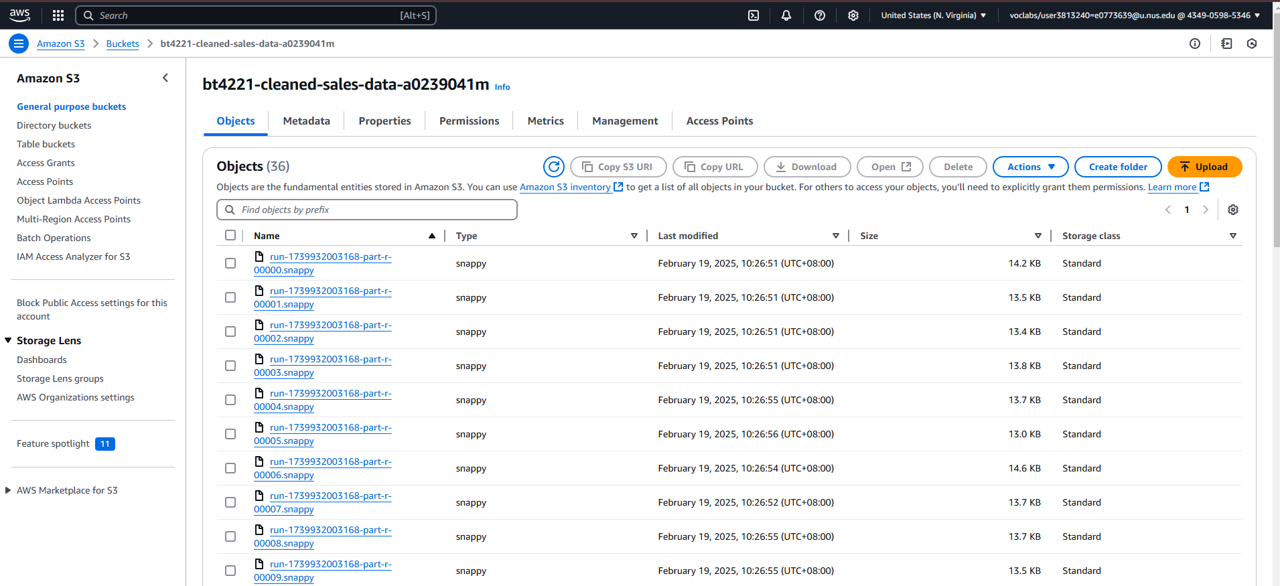

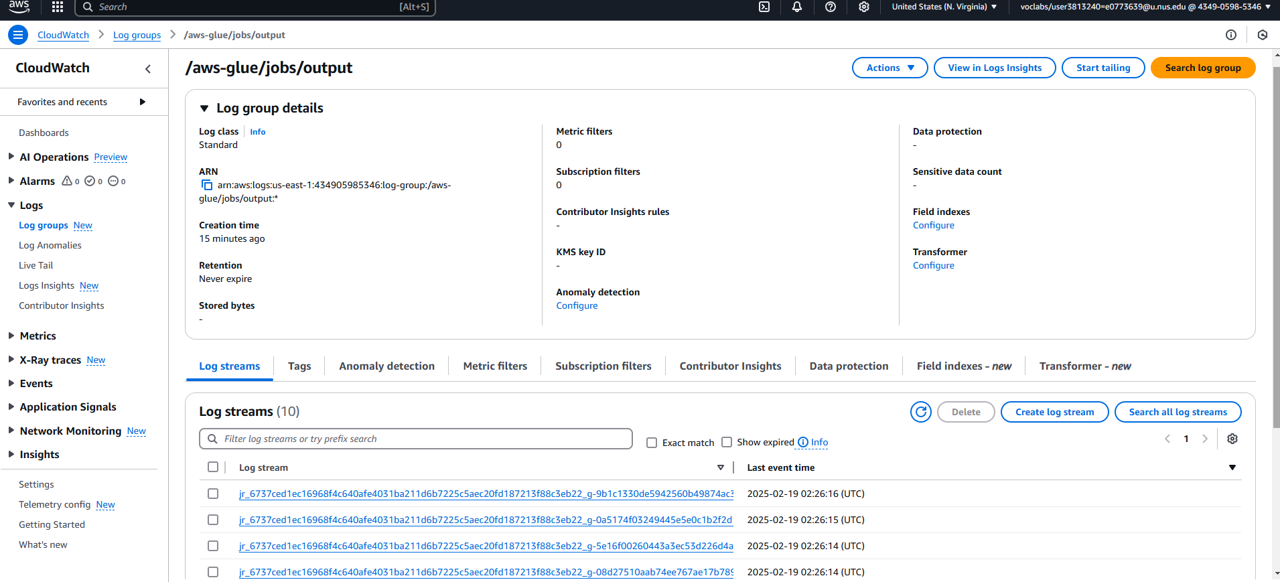

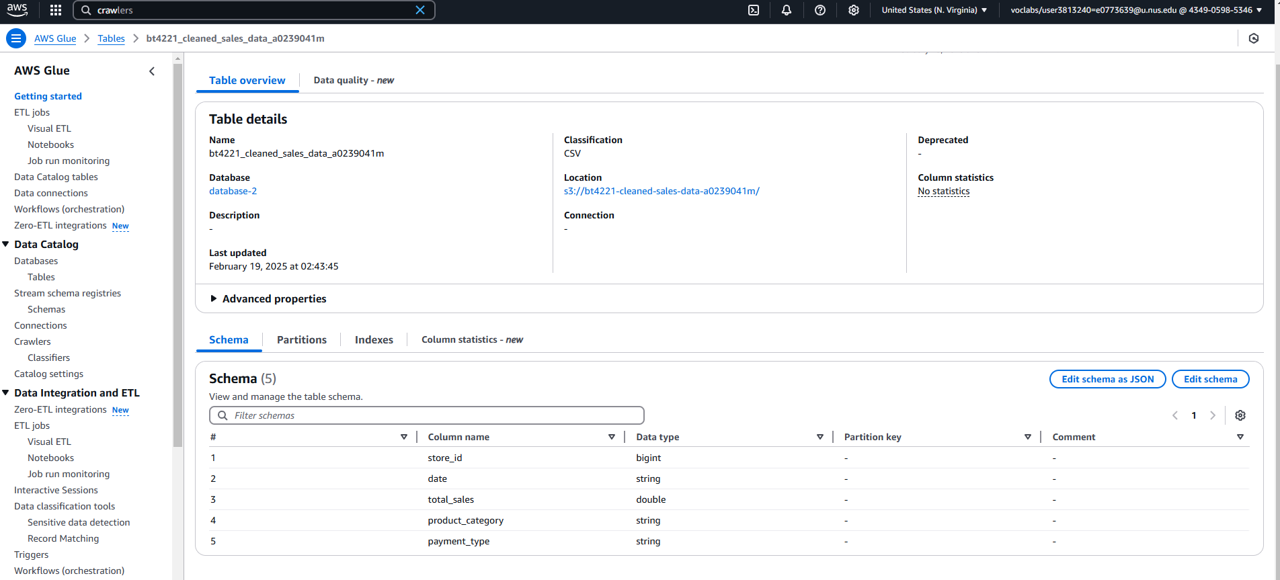

The screenshots shows the source S3 bucket ("bt4221-sales-data-a0239041m") as well as the target S3 bucket ("bt4221-cleaned-sales-data-a0239041m")

# Task 3: Apache Airflow Scheduled Execution

In [3]:
%%capture
# Install required packages
!pip install apache-airflow apache-airflow-providers-amazon kubernetes

In [4]:
%%capture
# Set up Airflow environment
import os
os.environ['AIRFLOW_HOME'] = '/content/airflow'
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

# Initialize the database
!airflow db init

# Create admin user
!airflow users create \
    --username bt4221 \
    --firstname X \
    --lastname Y \
    --role Admin \
    --email admin@example.com \
    --password password

# Create DAGs directory
!mkdir -p /content/airflow/dags
!airflow info

In [5]:
%%capture
!pip install aws
!pip install awscli

In [6]:
# You can input any junk values in Access Key ID and Secret Access Key as we are setting up full credentials in next step anyway
!aws configure

AWS Access Key ID [None]: 1
AWS Secret Access Key [None]: 1
Default region name [None]: 
Default output format [None]: 


In [ ]:
# COPY PASTE THIS FROM THE AWS LAB ENVIRONMENT
%%writefile ~/.aws/credentials
[default]
aws_access_key_id=
aws_secret_access_key=
aws_session_token=

Overwriting /root/.aws/credentials


In [8]:
%%capture
!pip install boto3

In [9]:
%%writefile /content/airflow/dags/bt4221_sales_pipeline.py

import boto3
from airflow import DAG
from airflow.operators.python import PythonOperator
from datetime import datetime, timedelta

# Define default arguments
default_args = {
    'start_date': datetime(2024, 1, 22),
    'retries': 3,
    'retry_delay': timedelta(minutes=5),
    'email_on_failure': False,
    'email_on_retry': False,
    'email': 'example@admin.com'
}

# Function to trigger the AWS Glue ETL job
def trigger_glue_job():
    glue_client = boto3.client('glue', region_name='us-east-1')
    job_name = "glue_etl_job"
    response = glue_client.start_job_run(JobName=job_name)
    job_run_id = response['JobRunId']
    print(f"Started Glue Job: {job_name}, Run ID: {job_run_id}")
    return job_run_id

# Define the DAG
with DAG(
    dag_id="bt4221_sales_pipeline",
    default_args=default_args,
    description='Triggers Glue ETL job daily @ 2:00 AM UTC',
    schedule_interval = '0 18 * * *',  # 2:00 AM UTC+8
    catchup=False,
) as dag:

    trigger_glue_job_task = PythonOperator(
        task_id='trigger_glue_job',
        python_callable=trigger_glue_job,
    )

trigger_glue_job_task

Writing /content/airflow/dags/bt4221_sales_pipeline.py


In [10]:
!python /content/airflow/dags/bt4221_sales_pipeline.py

/content/airflow/dags/bt4221_sales_pipeline.py:27 RemovedInAirflow3Warning: Param `schedule_interval` is deprecated and will be removed in a future release. Please use `schedule` instead.


In [11]:
# Start Airflow services
!nohup airflow webserver -p 8888 > webserver.log &

nohup: redirecting stderr to stdout


In [12]:
!nohup airflow scheduler > scheduler.log &

nohup: redirecting stderr to stdout


In [13]:
%%capture
!pip install pyngrok

In [ ]:
from pyngrok import ngrok

# Replace 'YOUR_AUTHTOKEN' with the actual authtoken you copied
# include the pair of single quotes
ngrok.set_auth_token('')

public_url = ngrok.connect(8888)
print(f"Airflow Web UI is available at: {public_url}")

Airflow Web UI is available at: NgrokTunnel: "https://bc94-34-45-58-140.ngrok-free.app" -> "http://localhost:8888"


## Screenshot of the Airflow UI home page showing that the webserver is running:

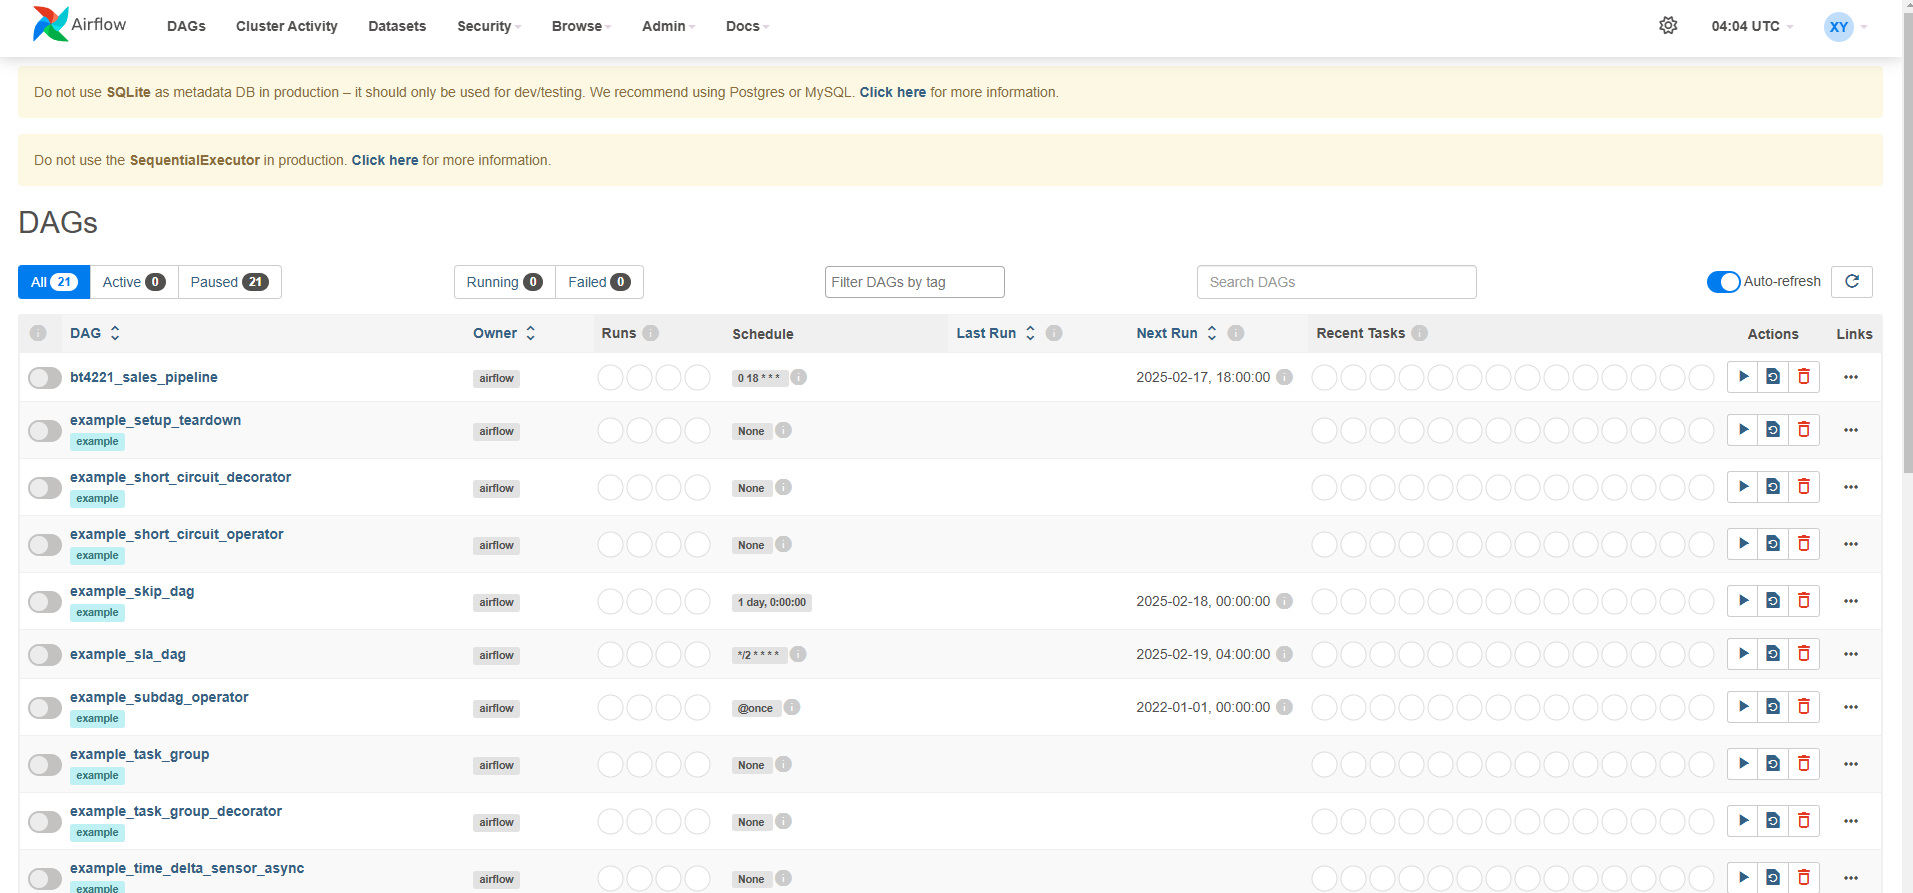

## Screenshot of the Airflow UI showing the DAG run status (running or completed):

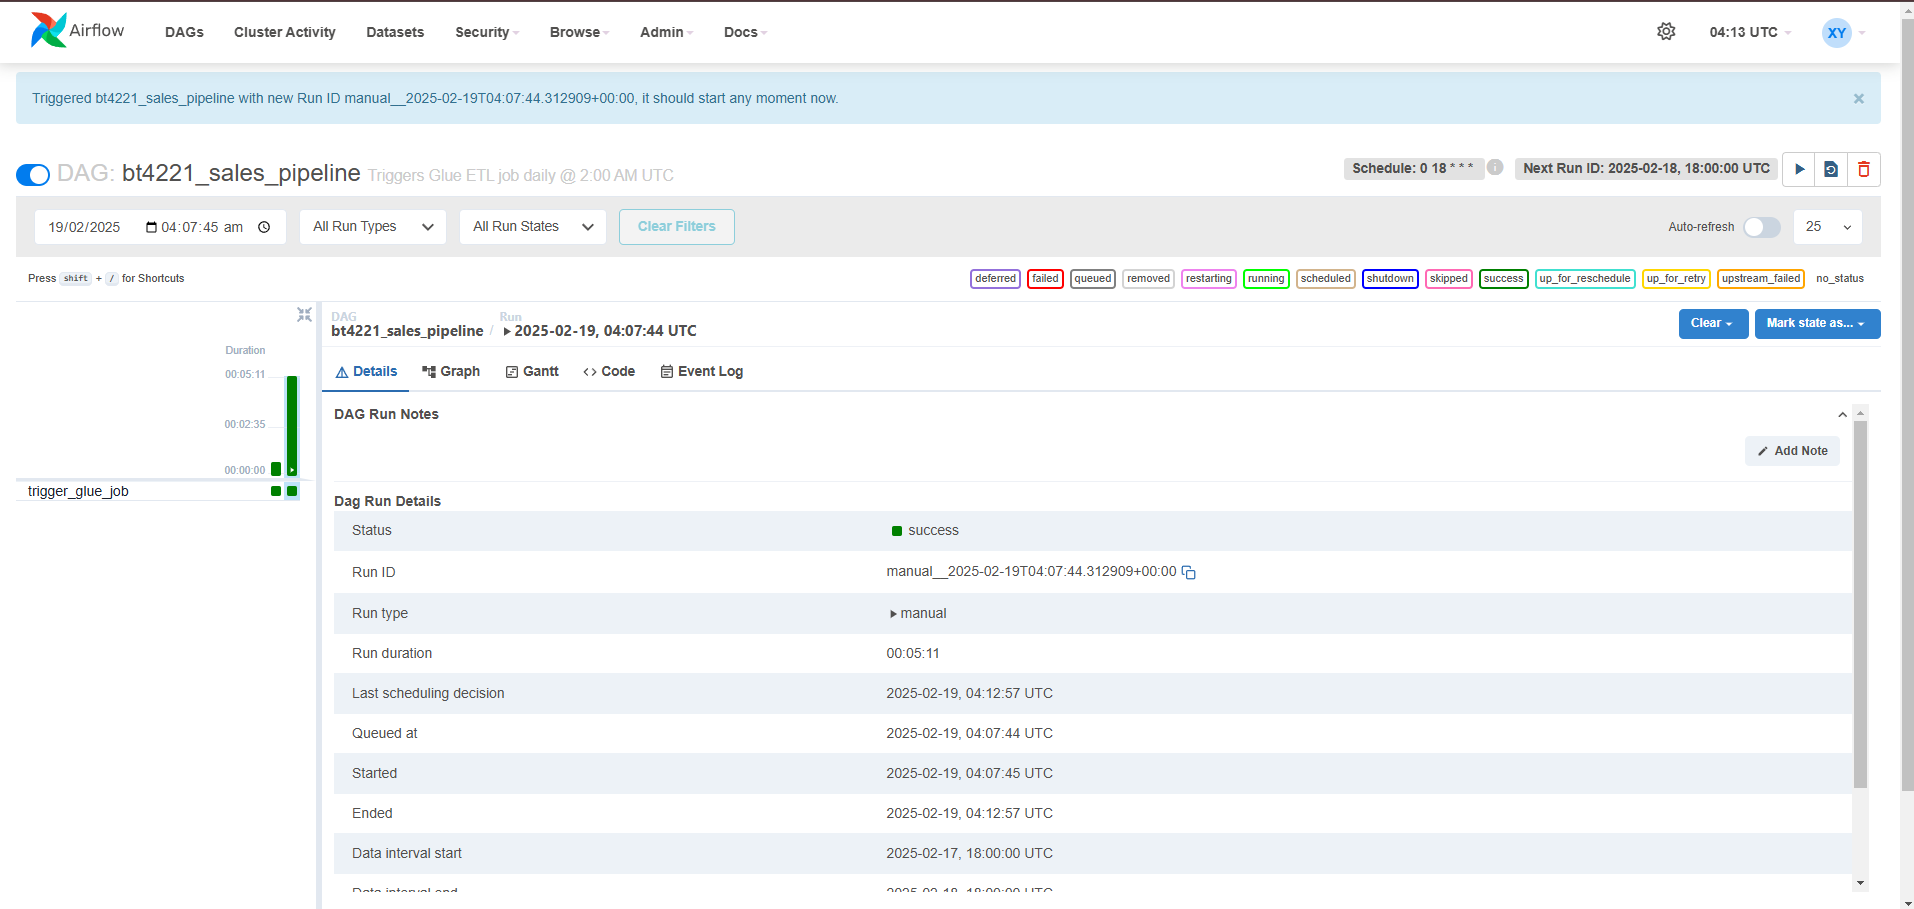

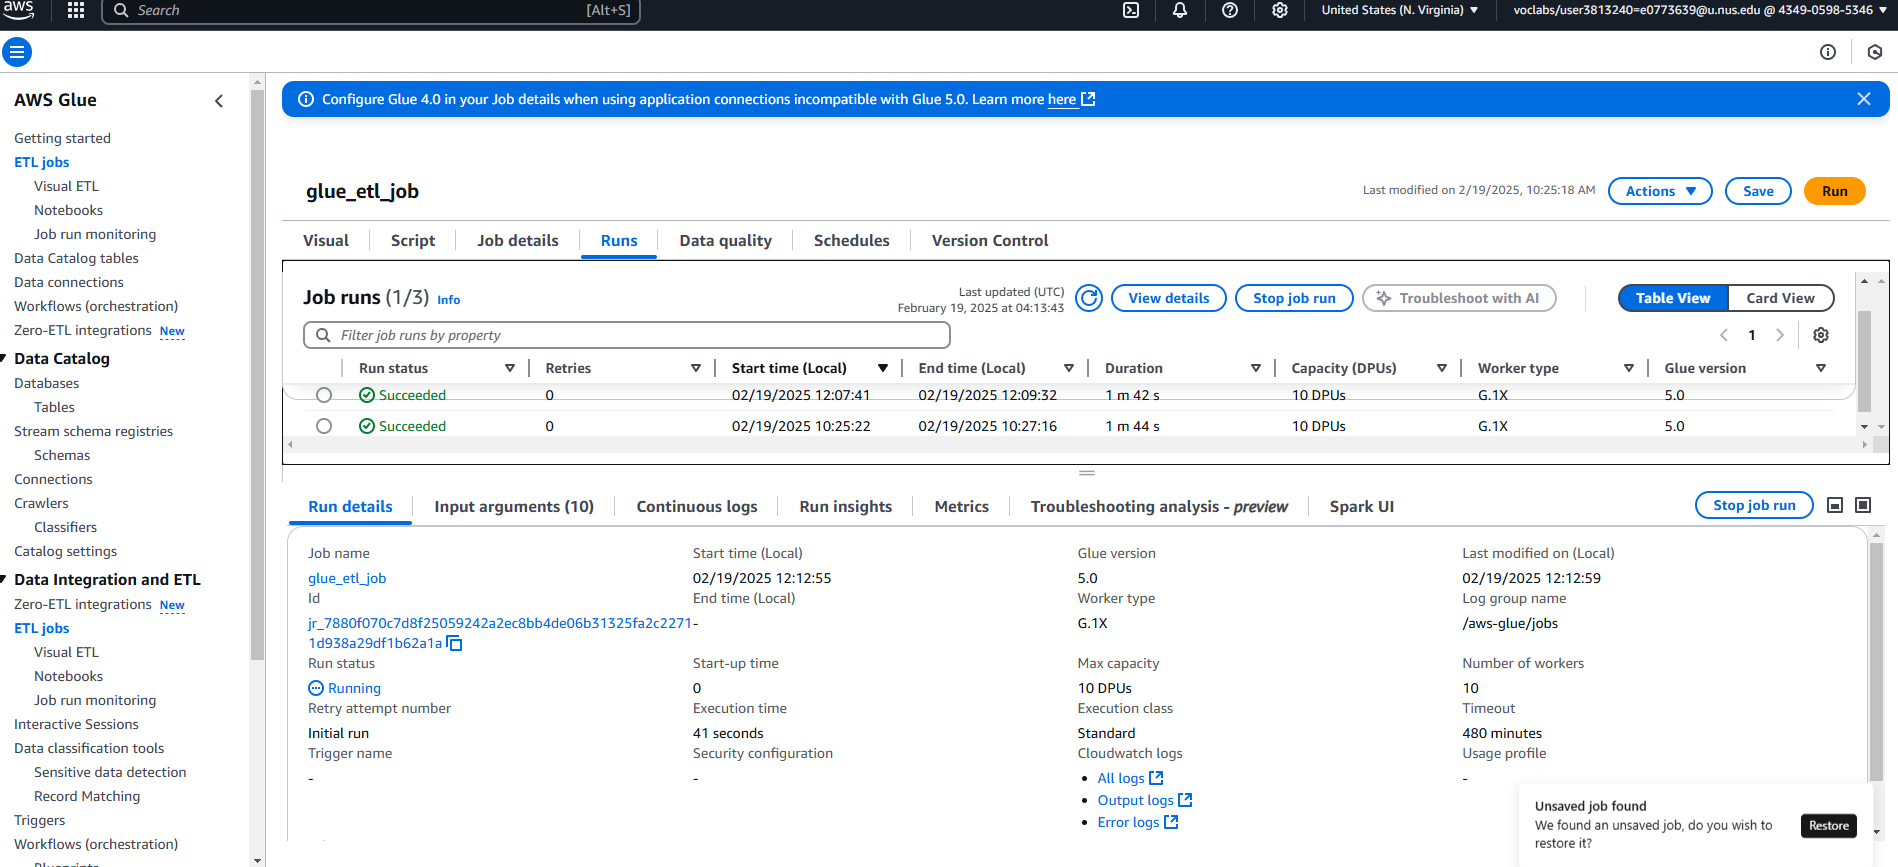

# Task 4: Handling uneven data distribution during transformation


## Describe the problem of uneven data distribution in the context of partitioning and bucketing:

Paritioning splits a large dataset into smaller datasets based on specific columns. Each partition will contain data which has the same value for that column, speeding up queries as queries become more efficient by scanning relevant partitions instead of the whole dataset. For instance, partitioning can split sales data by year. Bucketing distributes data into fixed buckets based on column hash value. Therefore, bucketing divides data into groups with fixed sizes instead of creating new folders for every unique value. For instance, during bucketing store_id values are hashed and assigned to one of the n number of buckets to ensure even distribution of data.

Bucketing and partitioning however face challenges with uneven distribution that can lead to inefficiencies, which include:

1. Skewed Processing Durations <br>
When queries access partitions that are unevenly-sized, queries have to scan more data than optimally necessary. This leads to queries becoming inefficient and taking significantly longer, especially when when the query have to scan through large partitions.

2. Wastage of Resources Due to Storage Imbalance <br>
When certain partitions utilise significantly more storage (eg. in AWS S3) than other paritions, it leads to higher storage costs. Frequent re-processing of large partitions increase computational costs and small paritions are underutilised, wasting storage.

3. Inefficient Usage of Resource Due to Bottlenecks in Processing <br>
ETL Jobs have to process all partitions before completing the required transformations. However, when certain large buckets or patitions receive significantly higher data volumes than other buckets or partitions, it creates a bottleneck as large buckets or partitions take longer. This delays data availability because the entire ETL job waits for the slowest parititon, and certain processing nodes will remain idle while the large paritions are being processed.

4. Slowdowns During Periods with High Volume <br>
During periods of high volume such as during promotions, heavily loaded paritions take longer to process, hence delaying the entire pipeline. This causes real-time analytics to become delayed or outdated, affecting decision-making.


## Propose at least two strategies to improve the distribution of data across partitions or buckets in the ETL pipeline to address the issue of uneven data processing:

### Strategy 1: Dynamic Paritioning
Dynamic partitioning adjusts partition size and structures based on real-time volume patterns and distribution instead of relying on static fixed partitions. Dynamic partitioning monitors the data volume within each parition, and creates sub-partitions when the predefined threshold of a partition is exceeded.

#### Implementation
We can utilise AWS Glue Dynamic Partitioning, which automatically adjusts partitions based on the incoming characteristics of the data. The pipeline will create partitions dynamically based on actual data volume. This is especially helpful when certain stores generate more sales than other stores in the context of the company. This causes data to skew. Hence, instead of partitioning by for instance, store_id, dynamic partitioning introduces the element of sub-partitions, for instance a sub partition date.

Before Dynamic Partitioning	<br>
store_id=201 (60GB)
store_id=202 (5GB)

After Dynamic Partitioning <br>
store_id=201/date=2024-02-01 (15GB), store_id=201/date=2024-02-02 (15GB) <br>
store_id=202 (5GB)

The ETL pipeline adapts to the changing data volumes without any further manual intervention, reducing ETL bottlenecks as no single partition now has too large amounts of data. This improves query performance because only the relevant partitions will be scanned, leading to reduced executation duration and reduced costs.

### Strategy 2: Salting for Bucketing
Salting is a technique in bucketing, where the bucket key is modified through the addition of a random value to ensure more even data distribution across buckets. A hash-based salt value is appended to each record to ensure that records from a specific store will be spread across different buckets.

#### Implementation
For instance, instead of storing only store_id, a hash-based salt value is appended to the record to spread the data evenly across different buckets. The salt values are also dynamically adjusted using previous data.

Before Salting - Skewed Buckets<br>
store_id=201 (50GB in one bucket)<br>
store_id=202 (60GB in one bucket)<br>
store_id=203 (5GB in one bucket)<br>
store_id=204 (3GB in one bucket)<br>

We introduce salting, where the store_id is modified by addding a salt value (hash-based). <br>
After Salting - Evenly Distributed Buckets<br>
store_id=201_0 (10GB)<br>
store_id=201_1 (10GB)<br>
store_id=201_2 (10GB)<br>
store_id=202_0 (12GB)<br>
store_id=202_1 (12GB)<br>
store_id=202_2 (12GB)<br>
store_id=203_0 (5GB)<br>
store_id=204_0 (3GB)<br>

This leads to a more balanced workload between buckets compared to normal bucketing where buckets may become hotspots (receive significantly more data than other buckets).

## What are the potential limitations or challenges for each approach?

### Strategy 1: Dynamic Paritioning
#### Additional Computational Costs from Real-Time Monitoring
An ETL pipeline with dynamic partitioning requires continuous, real-time monitoring of parition sizes to detect skewed partitions, which utilise additional computational resources in terms of increased costs from resources such as AWS Glue. Monitoring systems will also have to be tuned properly to prevent unecessary re-partitioning false triggers.

#### Additional Overhead from Repartitioning Current Datasets
Data will be rewritten when partitions are being reorganised, causing delays temporarily. Queries ran during repartitioning might face issues such as delayed execution time or inconsistencies tempoarily.

### Strategy 2: Salting for Bucketing
#### Additional Storage Costs Due to Additional Bucket Keys
There is an increased number of bucket keys which are unique due to salting, and this increases costs of AWS S3 Storage because of increased PUT/GET requests.

#### Increased Query Complexity
Salting distributes data across different buckets, hence there is an increased complexity for querying as these queries will have to retrieve the results across the different buckets. This may make it hard for BI tools to efficiently process queries.

## Conclusion

Dynamic partitioning can prevent oversized partitions based on real-time adaptation of partitions based on incoming data volume, ensuring efficient query execution. However, dynamic partitioning requires continuous monitoring, which may lead to increased computational costs and temporary delays during repartitioning.

Salting for Bucketing distributes high-volume store records across multiple buckets, reducing processing hotspots and improving query efficiency. However, salting introduces additional storage costs due to the creation of multiple salted bucket keys as well as increases query complexity.

Both strategies have their advantages as well as trade-offs. Therefore, a combination of Dynamic Partitioning and Salting can provide a comprehensive solution, ensuring even data distribution, improved ETL performance and optimized cost efficiency. Fine-tuning the approach based on real-time data characteristics can enhance the scalability and reliability of the ETL pipeline further, enabling quicker insights and better decision-making